In [1]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
import NiftiGenerator
import gc
import torch.nn.functional as F

In [2]:
model = smp.Unet(
    in_channels=1,
    encoder_name='resnet152',
    encoder_weights=None,
    activation='sigmoid'
).double()

In [3]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [4]:
DEVICE = 'cuda'
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [5]:
gc.collect()
torch.cuda.empty_cache()
x_data_train = './data/image'
y_data_train = './data/label'
x_data_val = './data/image_val'
y_data_val = './data/label_val'

In [7]:
# define the NiftiGenerator
niftiGen = NiftiGenerator.PairedNiftiGenerator()
# get augmentation options (see help for get_default_augOptions for more details! )
niftiGen_augment_opts = NiftiGenerator.PairedNiftiGenerator.get_default_augOptions()
niftiGen_augment_opts.hflips = True
niftiGen_augment_opts.vflips = True
niftiGen_augment_opts.rotations = 5
niftiGen_augment_opts.scalings = .1
# get normalization options ( see help for get_default_normOptions for more details! )
niftiGen_norm_opts = NiftiGenerator.PairedNiftiGenerator.get_default_normOptions()
niftiGen_norm_opts.normXtype = 'auto'
niftiGen_norm_opts.normYtype = 'none'
#niftiGen_norm_opts.normYoffset = 0
#niftiGen_norm_opts.normYscale = 50000
# initialize the generator (where x_data_train and y_data_train are either a paths to a single folder or lists of Nifti files)
niftiGen.initialize( x_data_train, y_data_train, augOptions=niftiGen_augment_opts, normOptions=niftiGen_norm_opts )
## in your training function you will then call something like:
#NiftiGenerator.generate_chunks( niftiGen, chunk_size=(32,32,32), batch_size=64 ) 
## to generate a batch of 64, 32x32x32 chunks of paired data

2021-09-09 01:35:18,327 NiftiGenerator INFO     50 datasets were found for X
2021-09-09 01:35:18,329 NiftiGenerator INFO     50 datasets were found for Y
2021-09-09 01:35:18,331 NiftiGenerator INFO     X normalization is auto. Computing normalizations now...


In [8]:
# define the NiftiGenerator
niftiGenVal = NiftiGenerator.PairedNiftiGenerator()
# get augmentation options (see help for get_default_augOptions for more details! )
niftiGen_augment_opts = NiftiGenerator.PairedNiftiGenerator.get_default_augOptions()
niftiGen_augment_opts.hflips = True
niftiGen_augment_opts.vflips = True
niftiGen_augment_opts.rotations = 5
niftiGen_augment_opts.scalings = .1
# get normalization options ( see help for get_default_normOptions for more details! )
niftiGen_norm_opts = NiftiGenerator.PairedNiftiGenerator.get_default_normOptions()
niftiGen_norm_opts.normXtype = 'auto'
niftiGen_norm_opts.normYtype = 'none'
#niftiGen_norm_opts.normYoffset = 0
#niftiGen_norm_opts.normYscale = 50000
# initialize the generator (where x_data_train and y_data_train are either a paths to a single folder or lists of Nifti files)
niftiGenVal.initialize( x_data_val, y_data_val, augOptions=niftiGen_augment_opts, normOptions=niftiGen_norm_opts )
## in your training function you will then call something like:
#NiftiGenerator.generate_chunks( niftiGen, chunk_size=(32,32,32), batch_size=64 ) 
## to generate a batch of 64, 32x32x32 chunks of paired data

2021-09-09 01:35:18,952 NiftiGenerator INFO     6 datasets were found for X
2021-09-09 01:35:18,953 NiftiGenerator INFO     6 datasets were found for Y
2021-09-09 01:35:18,953 NiftiGenerator INFO     X normalization is auto. Computing normalizations now...


In [ ]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(niftiGen)
    valid_logs = valid_epoch.run(niftiGenVal)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0


  0%|                                        | 1/1000 [00:04<1:13:53,  4.44s/it]

dice_loss - 0.6712, iou_score - 0.121


 10%|████                                    | 101/1000 [05:11<46:38,  3.11s/it]

dice_loss - 0.3901, iou_score - 0.5848


 20%|████████                                | 201/1000 [10:19<41:02,  3.08s/it]

dice_loss - 0.3161, iou_score - 0.6507


 30%|████████████                            | 301/1000 [15:27<35:49,  3.07s/it]

dice_loss - 0.2724, iou_score - 0.6887


 40%|████████████████                        | 401/1000 [20:35<30:48,  3.09s/it]

dice_loss - 0.2414, iou_score - 0.7164


 50%|████████████████████                    | 501/1000 [25:43<25:36,  3.08s/it]

dice_loss - 0.2179, iou_score - 0.7378


 60%|████████████████████████                | 601/1000 [30:51<20:28,  3.08s/it]

dice_loss - 0.2001, iou_score - 0.7542


 70%|████████████████████████████            | 701/1000 [35:59<15:20,  3.08s/it]

dice_loss - 0.1855, iou_score - 0.7678


 80%|████████████████████████████████        | 801/1000 [41:06<10:12,  3.08s/it]

dice_loss - 0.1734, iou_score - 0.7795


 90%|████████████████████████████████████    | 901/1000 [46:14<05:04,  3.08s/it]

dice_loss - 0.1631, iou_score - 0.7895


  0%|                                          | 1/1000 [00:01<21:31,  1.29s/it]

dice_loss - 0.256, iou_score - 0.5981


 10%|████                                    | 101/1000 [02:04<18:37,  1.24s/it]

dice_loss - 0.2138, iou_score - 0.6554


 20%|████████                                | 201/1000 [04:08<16:43,  1.26s/it]

dice_loss - 0.2154, iou_score - 0.6531


 30%|████████████                            | 301/1000 [06:12<14:26,  1.24s/it]

dice_loss - 0.2148, iou_score - 0.6538


 40%|████████████████                        | 401/1000 [08:15<12:27,  1.25s/it]

dice_loss - 0.2145, iou_score - 0.6543


 50%|████████████████████                    | 501/1000 [10:19<10:11,  1.23s/it]

dice_loss - 0.2148, iou_score - 0.6538


 60%|████████████████████████                | 601/1000 [12:22<08:08,  1.23s/it]

dice_loss - 0.2146, iou_score - 0.6541


 70%|████████████████████████████            | 701/1000 [14:26<06:09,  1.24s/it]

dice_loss - 0.2139, iou_score - 0.655


 80%|████████████████████████████████        | 801/1000 [16:30<04:06,  1.24s/it]

dice_loss - 0.214, iou_score - 0.6549


 90%|████████████████████████████████████    | 901/1000 [18:33<02:01,  1.23s/it]

dice_loss - 0.2139, iou_score - 0.6551


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]


Model saved!

Epoch: 1


  0%|                                          | 1/1000 [00:03<51:55,  3.12s/it]

dice_loss - 0.07022, iou_score - 0.8865


 10%|████                                    | 101/1000 [05:10<46:05,  3.08s/it]

dice_loss - 0.07124, iou_score - 0.8827


 20%|████████                                | 201/1000 [10:18<40:53,  3.07s/it]

dice_loss - 0.06963, iou_score - 0.8844


 30%|████████████                            | 301/1000 [15:26<35:48,  3.07s/it]

dice_loss - 0.06753, iou_score - 0.8874


 40%|████████████████                        | 401/1000 [20:33<30:43,  3.08s/it]

dice_loss - 0.0662, iou_score - 0.8891


 50%|████████████████████                    | 501/1000 [25:41<25:32,  3.07s/it]

dice_loss - 0.06464, iou_score - 0.8912


 60%|████████████████████████                | 601/1000 [30:49<20:26,  3.07s/it]

dice_loss - 0.06343, iou_score - 0.8928


 70%|████████████████████████████            | 701/1000 [35:56<15:20,  3.08s/it]

dice_loss - 0.06215, iou_score - 0.8946


 80%|████████████████████████████████        | 801/1000 [41:04<10:11,  3.07s/it]

dice_loss - 0.0611, iou_score - 0.896


 90%|████████████████████████████████████    | 901/1000 [46:11<05:04,  3.08s/it]

dice_loss - 0.06011, iou_score - 0.8974


  0%|                                          | 1/1000 [00:01<20:31,  1.23s/it]

dice_loss - 0.2025, iou_score - 0.6657


 10%|████                                    | 101/1000 [02:04<18:18,  1.22s/it]

dice_loss - 0.2167, iou_score - 0.6468


 20%|████████                                | 201/1000 [04:08<16:19,  1.23s/it]

dice_loss - 0.218, iou_score - 0.6451


 30%|████████████                            | 301/1000 [06:11<14:14,  1.22s/it]

dice_loss - 0.2185, iou_score - 0.6445


 40%|████████████████                        | 401/1000 [08:15<12:21,  1.24s/it]

dice_loss - 0.2185, iou_score - 0.6445


 50%|████████████████████                    | 501/1000 [10:18<10:09,  1.22s/it]

dice_loss - 0.2178, iou_score - 0.6454


 60%|████████████████████████                | 601/1000 [12:22<08:13,  1.24s/it]

dice_loss - 0.218, iou_score - 0.6452


 70%|████████████████████████████            | 701/1000 [14:25<06:10,  1.24s/it]

dice_loss - 0.2185, iou_score - 0.6445


 80%|████████████████████████████████        | 801/1000 [16:29<04:07,  1.24s/it]

dice_loss - 0.2181, iou_score - 0.6449


 90%|████████████████████████████████████    | 901/1000 [18:32<02:02,  1.24s/it]

dice_loss - 0.2182, iou_score - 0.6449


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]



Epoch: 2


  0%|                                          | 1/1000 [00:03<51:33,  3.10s/it]

dice_loss - 0.05088, iou_score - 0.9094


 10%|████                                    | 101/1000 [05:10<46:07,  3.08s/it]

dice_loss - 0.04958, iou_score - 0.9121


 20%|████████                                | 201/1000 [10:18<40:57,  3.08s/it]

dice_loss - 0.04883, iou_score - 0.9132


 30%|████████████                            | 301/1000 [15:25<35:45,  3.07s/it]

dice_loss - 0.04848, iou_score - 0.9137


 40%|████████████████                        | 401/1000 [20:33<30:44,  3.08s/it]

dice_loss - 0.04773, iou_score - 0.9149


 50%|████████████████████                    | 501/1000 [25:40<25:35,  3.08s/it]

dice_loss - 0.0472, iou_score - 0.9157


 60%|████████████████████████                | 601/1000 [30:48<20:25,  3.07s/it]

dice_loss - 0.04668, iou_score - 0.9166


 70%|████████████████████████████            | 701/1000 [35:56<15:18,  3.07s/it]

dice_loss - 0.04617, iou_score - 0.9174


 80%|████████████████████████████████        | 801/1000 [41:03<10:13,  3.08s/it]

dice_loss - 0.0458, iou_score - 0.9179


 90%|████████████████████████████████████    | 901/1000 [46:11<05:05,  3.09s/it]

dice_loss - 0.04532, iou_score - 0.9187


  0%|                                          | 1/1000 [00:01<21:07,  1.27s/it]

dice_loss - 0.1924, iou_score - 0.6789


 10%|████                                    | 101/1000 [02:05<18:31,  1.24s/it]

dice_loss - 0.2082, iou_score - 0.6574


 20%|████████                                | 201/1000 [04:08<16:19,  1.23s/it]

dice_loss - 0.2067, iou_score - 0.6595


 30%|████████████                            | 301/1000 [06:11<14:29,  1.24s/it]

dice_loss - 0.2063, iou_score - 0.66


 40%|████████████████                        | 401/1000 [08:15<12:28,  1.25s/it]

dice_loss - 0.2081, iou_score - 0.6577


 50%|████████████████████                    | 501/1000 [10:19<10:21,  1.25s/it]

dice_loss - 0.2076, iou_score - 0.6583


 60%|████████████████████████                | 601/1000 [12:22<08:15,  1.24s/it]

dice_loss - 0.2074, iou_score - 0.6586


 70%|████████████████████████████            | 701/1000 [14:26<06:10,  1.24s/it]

dice_loss - 0.2069, iou_score - 0.6593


 80%|████████████████████████████████        | 801/1000 [16:29<04:07,  1.24s/it]

dice_loss - 0.2073, iou_score - 0.6588


 90%|████████████████████████████████████    | 901/1000 [18:33<02:03,  1.24s/it]

dice_loss - 0.2071, iou_score - 0.659


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]


Model saved!

Epoch: 3


  0%|                                          | 1/1000 [00:03<52:16,  3.14s/it]

dice_loss - 0.04263, iou_score - 0.9229


 10%|████                                    | 101/1000 [05:11<46:02,  3.07s/it]

dice_loss - 0.04074, iou_score - 0.9258


 20%|████████                                | 201/1000 [10:18<40:56,  3.07s/it]

dice_loss - 0.04072, iou_score - 0.9257


 30%|████████████                            | 301/1000 [15:26<35:51,  3.08s/it]

dice_loss - 0.04057, iou_score - 0.9259


 40%|████████████████                        | 401/1000 [20:33<30:41,  3.07s/it]

dice_loss - 0.04025, iou_score - 0.9265


 50%|████████████████████                    | 501/1000 [25:41<25:33,  3.07s/it]

dice_loss - 0.03991, iou_score - 0.927


 60%|████████████████████████                | 601/1000 [30:49<20:26,  3.07s/it]

dice_loss - 0.03956, iou_score - 0.9276


 70%|████████████████████████████            | 701/1000 [35:56<15:18,  3.07s/it]

dice_loss - 0.0392, iou_score - 0.9282


 80%|████████████████████████████████        | 801/1000 [41:03<10:12,  3.08s/it]

dice_loss - 0.0389, iou_score - 0.9287


 90%|████████████████████████████████████    | 901/1000 [46:11<05:04,  3.08s/it]

dice_loss - 0.03862, iou_score - 0.9292


  0%|                                          | 1/1000 [00:01<20:53,  1.25s/it]

dice_loss - 0.1972, iou_score - 0.6716


 10%|████                                    | 101/1000 [02:04<18:27,  1.23s/it]

dice_loss - 0.2103, iou_score - 0.6541


 20%|████████                                | 201/1000 [04:08<16:24,  1.23s/it]

dice_loss - 0.2143, iou_score - 0.6487


 30%|████████████                            | 301/1000 [06:11<14:16,  1.23s/it]

dice_loss - 0.2145, iou_score - 0.6485


 40%|████████████████                        | 401/1000 [08:14<12:13,  1.22s/it]

dice_loss - 0.2153, iou_score - 0.6474


 50%|████████████████████                    | 501/1000 [10:17<10:25,  1.25s/it]

dice_loss - 0.2144, iou_score - 0.6486


 60%|████████████████████████                | 601/1000 [12:21<08:15,  1.24s/it]

dice_loss - 0.2144, iou_score - 0.6486


 70%|████████████████████████████            | 701/1000 [14:24<06:07,  1.23s/it]

dice_loss - 0.2145, iou_score - 0.6485


 80%|████████████████████████████████        | 801/1000 [16:27<04:03,  1.22s/it]

dice_loss - 0.2145, iou_score - 0.6484


 90%|████████████████████████████████████    | 901/1000 [18:31<02:02,  1.24s/it]

dice_loss - 0.2147, iou_score - 0.6482


100%|███████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]



Epoch: 4


  0%|                                          | 1/1000 [00:03<51:23,  3.09s/it]

dice_loss - 0.0329, iou_score - 0.9393


 10%|████                                    | 101/1000 [05:10<46:02,  3.07s/it]

dice_loss - 0.03563, iou_score - 0.9341


 20%|████████                                | 201/1000 [10:18<40:57,  3.08s/it]

dice_loss - 0.03536, iou_score - 0.9345


 30%|████████████                            | 301/1000 [15:26<35:49,  3.08s/it]

dice_loss - 0.03498, iou_score - 0.9352


 40%|████████████████                        | 401/1000 [20:33<30:46,  3.08s/it]

dice_loss - 0.03476, iou_score - 0.9356


 50%|████████████████████                    | 501/1000 [25:40<25:31,  3.07s/it]

dice_loss - 0.03445, iou_score - 0.9361


 60%|████████████████████████                | 601/1000 [30:48<20:26,  3.07s/it]

dice_loss - 0.03417, iou_score - 0.9366


 70%|████████████████████████████            | 701/1000 [35:56<15:19,  3.07s/it]

dice_loss - 0.03421, iou_score - 0.9365


 80%|████████████████████████████████        | 801/1000 [41:03<10:10,  3.07s/it]

dice_loss - 0.0341, iou_score - 0.9366


 90%|████████████████████████████████████    | 901/1000 [46:11<05:04,  3.07s/it]

dice_loss - 0.03405, iou_score - 0.9367


  0%|                                          | 1/1000 [00:01<20:46,  1.25s/it]

dice_loss - 0.2032, iou_score - 0.663


 10%|████                                    | 101/1000 [02:04<18:44,  1.25s/it]

dice_loss - 0.2116, iou_score - 0.6521


 20%|████████                                | 201/1000 [04:07<16:17,  1.22s/it]

dice_loss - 0.2151, iou_score - 0.6474


 30%|████████████                            | 301/1000 [06:11<14:29,  1.24s/it]

dice_loss - 0.2151, iou_score - 0.6473


 40%|████████████████                        | 401/1000 [08:14<12:12,  1.22s/it]

dice_loss - 0.2141, iou_score - 0.6488


 50%|████████████████████                    | 501/1000 [10:18<10:18,  1.24s/it]

dice_loss - 0.2137, iou_score - 0.6493


 60%|████████████████████████                | 601/1000 [12:22<08:14,  1.24s/it]

dice_loss - 0.2142, iou_score - 0.6485


 70%|████████████████████████████            | 701/1000 [14:25<06:10,  1.24s/it]

dice_loss - 0.2147, iou_score - 0.6479


 80%|████████████████████████████████        | 801/1000 [16:29<04:09,  1.25s/it]

dice_loss - 0.2143, iou_score - 0.6484


 90%|████████████████████████████████████    | 901/1000 [18:32<02:03,  1.25s/it]

dice_loss - 0.2137, iou_score - 0.6492


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]



Epoch: 5


  0%|                                          | 1/1000 [00:03<51:37,  3.10s/it]

dice_loss - 0.03629, iou_score - 0.9323


 10%|████                                    | 101/1000 [05:11<46:10,  3.08s/it]

dice_loss - 0.03246, iou_score - 0.9392


 20%|████████                                | 201/1000 [10:18<40:52,  3.07s/it]

dice_loss - 0.03202, iou_score - 0.94


 30%|████████████                            | 301/1000 [15:26<35:48,  3.07s/it]

dice_loss - 0.03159, iou_score - 0.9408


 40%|████████████████                        | 401/1000 [20:33<30:42,  3.08s/it]

dice_loss - 0.03129, iou_score - 0.9414


 50%|████████████████████                    | 501/1000 [25:41<25:34,  3.08s/it]

dice_loss - 0.03115, iou_score - 0.9416


 60%|████████████████████████                | 601/1000 [30:48<20:26,  3.07s/it]

dice_loss - 0.03095, iou_score - 0.942


 70%|████████████████████████████            | 701/1000 [35:55<15:18,  3.07s/it]

dice_loss - 0.03074, iou_score - 0.9423


 80%|████████████████████████████████        | 801/1000 [41:03<10:11,  3.07s/it]

dice_loss - 0.03063, iou_score - 0.9425


 90%|████████████████████████████████████    | 901/1000 [46:10<05:04,  3.08s/it]

dice_loss - 0.03076, iou_score - 0.9422


  0%|                                          | 1/1000 [00:01<21:14,  1.28s/it]

dice_loss - 0.2206, iou_score - 0.6392


 10%|████                                    | 101/1000 [02:04<18:23,  1.23s/it]

dice_loss - 0.2092, iou_score - 0.6554


 20%|████████                                | 201/1000 [04:08<16:36,  1.25s/it]

dice_loss - 0.2069, iou_score - 0.6585


 30%|████████████                            | 301/1000 [06:12<14:22,  1.23s/it]

dice_loss - 0.2058, iou_score - 0.66


 40%|████████████████                        | 401/1000 [08:15<12:18,  1.23s/it]

dice_loss - 0.2061, iou_score - 0.6596


 50%|████████████████████                    | 501/1000 [10:19<10:15,  1.23s/it]

dice_loss - 0.2055, iou_score - 0.6605


 60%|████████████████████████                | 601/1000 [12:23<08:15,  1.24s/it]

dice_loss - 0.205, iou_score - 0.6612


 70%|████████████████████████████            | 701/1000 [14:26<06:12,  1.24s/it]

dice_loss - 0.2048, iou_score - 0.6615


 80%|████████████████████████████████        | 801/1000 [16:29<04:02,  1.22s/it]

dice_loss - 0.2049, iou_score - 0.6613


 90%|████████████████████████████████████    | 901/1000 [18:33<02:01,  1.23s/it]

dice_loss - 0.2048, iou_score - 0.6615


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]


Model saved!

Epoch: 6


  0%|                                          | 1/1000 [00:03<52:26,  3.15s/it]

dice_loss - 0.02992, iou_score - 0.9436


 10%|████                                    | 101/1000 [05:10<46:04,  3.08s/it]

dice_loss - 0.02921, iou_score - 0.9449


 20%|████████                                | 201/1000 [10:18<40:56,  3.07s/it]

dice_loss - 0.02913, iou_score - 0.945


 30%|████████████                            | 301/1000 [15:26<35:49,  3.07s/it]

dice_loss - 0.029, iou_score - 0.9452


 40%|████████████████                        | 401/1000 [20:33<30:45,  3.08s/it]

dice_loss - 0.02881, iou_score - 0.9456


 50%|████████████████████                    | 501/1000 [25:41<25:35,  3.08s/it]

dice_loss - 0.02865, iou_score - 0.9459


 60%|████████████████████████                | 601/1000 [30:48<20:28,  3.08s/it]

dice_loss - 0.02845, iou_score - 0.9462


 70%|████████████████████████████            | 701/1000 [35:56<15:18,  3.07s/it]

dice_loss - 0.02837, iou_score - 0.9464


 80%|████████████████████████████████        | 801/1000 [41:03<10:12,  3.08s/it]

dice_loss - 0.02837, iou_score - 0.9463


 90%|████████████████████████████████████    | 901/1000 [46:10<05:04,  3.07s/it]

dice_loss - 0.02838, iou_score - 0.9463


  0%|                                          | 1/1000 [00:01<21:20,  1.28s/it]

dice_loss - 0.1857, iou_score - 0.687


 10%|████                                    | 101/1000 [02:04<18:33,  1.24s/it]

dice_loss - 0.2025, iou_score - 0.6642


 20%|████████                                | 201/1000 [04:08<16:26,  1.23s/it]

dice_loss - 0.2059, iou_score - 0.6598


 30%|████████████                            | 301/1000 [06:12<14:24,  1.24s/it]

dice_loss - 0.2062, iou_score - 0.6594


 40%|████████████████                        | 401/1000 [08:15<12:15,  1.23s/it]

dice_loss - 0.2048, iou_score - 0.6612


 50%|████████████████████                    | 501/1000 [10:19<10:18,  1.24s/it]

dice_loss - 0.2042, iou_score - 0.662


 60%|████████████████████████                | 601/1000 [12:23<08:15,  1.24s/it]

dice_loss - 0.2044, iou_score - 0.6618


 70%|████████████████████████████            | 701/1000 [14:27<06:12,  1.24s/it]

dice_loss - 0.2047, iou_score - 0.6613


 80%|████████████████████████████████        | 801/1000 [16:30<04:04,  1.23s/it]

dice_loss - 0.2043, iou_score - 0.6619


 90%|████████████████████████████████████    | 901/1000 [18:34<02:03,  1.24s/it]

dice_loss - 0.2048, iou_score - 0.6613


100%|███████████████████████████████████████| 1000/1000 [20:37<00:00,  1.24s/it]



Epoch: 7


  0%|                                          | 1/1000 [00:03<51:39,  3.10s/it]

dice_loss - 0.02885, iou_score - 0.9448


 10%|████                                    | 101/1000 [05:11<46:08,  3.08s/it]

dice_loss - 0.02783, iou_score - 0.9472


 20%|████████                                | 201/1000 [10:19<41:01,  3.08s/it]

dice_loss - 0.02759, iou_score - 0.9476


 30%|████████████                            | 301/1000 [15:26<35:54,  3.08s/it]

dice_loss - 0.02734, iou_score - 0.9481


 40%|████████████████                        | 401/1000 [20:34<30:43,  3.08s/it]

dice_loss - 0.02706, iou_score - 0.9486


 50%|████████████████████                    | 501/1000 [25:41<25:33,  3.07s/it]

dice_loss - 0.02701, iou_score - 0.9487


 60%|████████████████████████                | 601/1000 [30:49<20:27,  3.08s/it]

dice_loss - 0.02684, iou_score - 0.949


 70%|████████████████████████████            | 701/1000 [35:56<15:20,  3.08s/it]

dice_loss - 0.02666, iou_score - 0.9493


 80%|████████████████████████████████        | 801/1000 [41:04<10:12,  3.08s/it]

dice_loss - 0.02651, iou_score - 0.9496


 90%|████████████████████████████████████    | 901/1000 [46:11<05:04,  3.07s/it]

dice_loss - 0.02642, iou_score - 0.9497


  0%|                                          | 1/1000 [00:01<21:38,  1.30s/it]

dice_loss - 0.1484, iou_score - 0.7416


 10%|████                                    | 101/1000 [02:04<18:36,  1.24s/it]

dice_loss - 0.1923, iou_score - 0.6786


 20%|████████                                | 201/1000 [04:08<16:32,  1.24s/it]

dice_loss - 0.1927, iou_score - 0.678


 30%|████████████                            | 301/1000 [06:12<14:15,  1.22s/it]

dice_loss - 0.1927, iou_score - 0.6779


 40%|████████████████                        | 401/1000 [08:15<12:21,  1.24s/it]

dice_loss - 0.1916, iou_score - 0.6795


 50%|████████████████████                    | 501/1000 [10:18<10:09,  1.22s/it]

dice_loss - 0.1925, iou_score - 0.6783


 60%|████████████████████████                | 601/1000 [12:22<08:10,  1.23s/it]

dice_loss - 0.192, iou_score - 0.679


 70%|████████████████████████████            | 701/1000 [14:26<06:12,  1.24s/it]

dice_loss - 0.192, iou_score - 0.6789


 80%|████████████████████████████████        | 801/1000 [16:29<04:07,  1.25s/it]

dice_loss - 0.1929, iou_score - 0.6777


 90%|████████████████████████████████████    | 901/1000 [18:33<02:01,  1.23s/it]

dice_loss - 0.193, iou_score - 0.6775


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]


Model saved!

Epoch: 8


  0%|                                          | 1/1000 [00:03<51:59,  3.12s/it]

dice_loss - 0.02335, iou_score - 0.9553


 10%|████                                    | 101/1000 [05:10<46:07,  3.08s/it]

dice_loss - 0.02524, iou_score - 0.9519


 20%|████████                                | 201/1000 [10:18<40:51,  3.07s/it]

dice_loss - 0.02539, iou_score - 0.9515


 30%|████████████                            | 301/1000 [15:25<35:45,  3.07s/it]

dice_loss - 0.02527, iou_score - 0.9518


 40%|████████████████                        | 401/1000 [20:32<30:39,  3.07s/it]

dice_loss - 0.02518, iou_score - 0.9519


 50%|████████████████████                    | 501/1000 [25:39<25:29,  3.07s/it]

dice_loss - 0.02514, iou_score - 0.952


 60%|████████████████████████                | 601/1000 [30:46<20:27,  3.08s/it]

dice_loss - 0.02504, iou_score - 0.9522


 70%|████████████████████████████            | 701/1000 [35:53<15:18,  3.07s/it]

dice_loss - 0.02504, iou_score - 0.9522


 80%|████████████████████████████████        | 801/1000 [41:01<10:11,  3.07s/it]

dice_loss - 0.02495, iou_score - 0.9523


 90%|████████████████████████████████████    | 901/1000 [46:08<05:04,  3.07s/it]

dice_loss - 0.02485, iou_score - 0.9525


  0%|                                          | 1/1000 [00:01<20:46,  1.25s/it]

dice_loss - 0.2137, iou_score - 0.6479


 10%|████                                    | 101/1000 [02:04<18:25,  1.23s/it]

dice_loss - 0.2016, iou_score - 0.6656


 20%|████████                                | 201/1000 [04:07<16:17,  1.22s/it]

dice_loss - 0.1998, iou_score - 0.6681


 30%|████████████                            | 301/1000 [06:10<14:15,  1.22s/it]

dice_loss - 0.2013, iou_score - 0.6659


 40%|████████████████                        | 401/1000 [08:13<12:14,  1.23s/it]

dice_loss - 0.1995, iou_score - 0.6684


 50%|████████████████████                    | 501/1000 [10:17<10:25,  1.25s/it]

dice_loss - 0.2007, iou_score - 0.6668


 60%|████████████████████████                | 601/1000 [12:20<08:13,  1.24s/it]

dice_loss - 0.2009, iou_score - 0.6665


 70%|████████████████████████████            | 701/1000 [14:24<06:05,  1.22s/it]

dice_loss - 0.2011, iou_score - 0.6662


 80%|████████████████████████████████        | 801/1000 [16:27<04:07,  1.24s/it]

dice_loss - 0.201, iou_score - 0.6663


 90%|████████████████████████████████████    | 901/1000 [18:30<02:01,  1.23s/it]

dice_loss - 0.201, iou_score - 0.6664


100%|███████████████████████████████████████| 1000/1000 [20:32<00:00,  1.23s/it]



Epoch: 9


  0%|                                          | 1/1000 [00:03<51:31,  3.09s/it]

dice_loss - 0.02297, iou_score - 0.956


 10%|████                                    | 101/1000 [05:10<46:11,  3.08s/it]

dice_loss - 0.02418, iou_score - 0.9537


 20%|████████                                | 201/1000 [10:18<41:01,  3.08s/it]

dice_loss - 0.02406, iou_score - 0.9539


 30%|████████████                            | 301/1000 [15:25<35:48,  3.07s/it]

dice_loss - 0.0239, iou_score - 0.9542


 40%|████████████████                        | 401/1000 [20:33<30:38,  3.07s/it]

dice_loss - 0.02411, iou_score - 0.9538


 50%|████████████████████                    | 501/1000 [25:40<25:32,  3.07s/it]

dice_loss - 0.02412, iou_score - 0.9538


 60%|████████████████████████                | 601/1000 [30:47<20:24,  3.07s/it]

dice_loss - 0.02407, iou_score - 0.9539


 70%|████████████████████████████            | 701/1000 [35:54<15:18,  3.07s/it]

dice_loss - 0.02397, iou_score - 0.954


 80%|████████████████████████████████        | 801/1000 [41:02<10:12,  3.08s/it]

dice_loss - 0.02382, iou_score - 0.9543


 90%|████████████████████████████████████    | 901/1000 [46:09<05:04,  3.07s/it]

dice_loss - 0.02374, iou_score - 0.9545


  0%|                                          | 1/1000 [00:01<21:34,  1.30s/it]

dice_loss - 0.2318, iou_score - 0.6238


 10%|████                                    | 101/1000 [02:04<18:18,  1.22s/it]

dice_loss - 0.2058, iou_score - 0.6597


 20%|████████                                | 201/1000 [04:07<16:19,  1.23s/it]

dice_loss - 0.2036, iou_score - 0.6628


 30%|████████████                            | 301/1000 [06:11<14:29,  1.24s/it]

dice_loss - 0.2032, iou_score - 0.6633


 40%|████████████████                        | 401/1000 [08:14<12:14,  1.23s/it]

dice_loss - 0.2037, iou_score - 0.6625


 50%|████████████████████                    | 501/1000 [10:17<10:10,  1.22s/it]

dice_loss - 0.2035, iou_score - 0.6629


 60%|████████████████████████                | 601/1000 [12:21<08:09,  1.23s/it]

dice_loss - 0.2038, iou_score - 0.6625


 70%|████████████████████████████            | 701/1000 [14:25<06:10,  1.24s/it]

dice_loss - 0.2038, iou_score - 0.6624


 80%|████████████████████████████████        | 801/1000 [16:28<04:08,  1.25s/it]

dice_loss - 0.2038, iou_score - 0.6624


 90%|████████████████████████████████████    | 901/1000 [18:31<02:03,  1.24s/it]

dice_loss - 0.2035, iou_score - 0.6629


100%|███████████████████████████████████████| 1000/1000 [20:34<00:00,  1.23s/it]



Epoch: 10


  0%|                                          | 1/1000 [00:03<51:21,  3.08s/it]

dice_loss - 0.02144, iou_score - 0.9587


 10%|████                                    | 101/1000 [05:10<46:12,  3.08s/it]

dice_loss - 0.02287, iou_score - 0.956


 20%|████████                                | 201/1000 [10:17<40:58,  3.08s/it]

dice_loss - 0.02271, iou_score - 0.9563


 30%|████████████                            | 301/1000 [15:25<36:13,  3.11s/it]

dice_loss - 0.02272, iou_score - 0.9563


 40%|████████████████                        | 401/1000 [20:34<30:45,  3.08s/it]

dice_loss - 0.02264, iou_score - 0.9565


 50%|████████████████████                    | 501/1000 [25:41<25:34,  3.08s/it]

dice_loss - 0.02262, iou_score - 0.9565


 60%|████████████████████████                | 601/1000 [30:48<20:25,  3.07s/it]

dice_loss - 0.02259, iou_score - 0.9566


 70%|████████████████████████████            | 701/1000 [35:55<15:18,  3.07s/it]

dice_loss - 0.02256, iou_score - 0.9566


 80%|████████████████████████████████        | 801/1000 [41:03<10:10,  3.07s/it]

dice_loss - 0.0225, iou_score - 0.9567


 90%|████████████████████████████████████    | 901/1000 [46:10<05:03,  3.07s/it]

dice_loss - 0.02246, iou_score - 0.9568


  0%|                                          | 1/1000 [00:01<20:57,  1.26s/it]

dice_loss - 0.1695, iou_score - 0.7104


 10%|████                                    | 101/1000 [02:05<18:38,  1.24s/it]

dice_loss - 0.2053, iou_score - 0.6603


 20%|████████                                | 201/1000 [04:08<16:14,  1.22s/it]

dice_loss - 0.2055, iou_score - 0.6601


 30%|████████████                            | 301/1000 [06:11<14:22,  1.23s/it]

dice_loss - 0.2045, iou_score - 0.6614


 40%|████████████████                        | 401/1000 [08:15<12:13,  1.23s/it]

dice_loss - 0.2041, iou_score - 0.662


 50%|████████████████████                    | 501/1000 [10:18<10:18,  1.24s/it]

dice_loss - 0.2035, iou_score - 0.6629


 60%|████████████████████████                | 601/1000 [12:21<08:11,  1.23s/it]

dice_loss - 0.2037, iou_score - 0.6625


 70%|████████████████████████████            | 701/1000 [14:25<06:07,  1.23s/it]

dice_loss - 0.2041, iou_score - 0.662


 80%|████████████████████████████████        | 801/1000 [16:28<04:04,  1.23s/it]

dice_loss - 0.2045, iou_score - 0.6614


 90%|████████████████████████████████████    | 901/1000 [18:31<02:01,  1.23s/it]

dice_loss - 0.205, iou_score - 0.6608


100%|███████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]



Epoch: 11


  0%|                                          | 1/1000 [00:03<51:28,  3.09s/it]

dice_loss - 0.02369, iou_score - 0.9544


 10%|████                                    | 101/1000 [05:10<46:02,  3.07s/it]

dice_loss - 0.0221, iou_score - 0.9574


 20%|████████                                | 201/1000 [10:17<40:52,  3.07s/it]

dice_loss - 0.02195, iou_score - 0.9577


 30%|████████████                            | 301/1000 [15:25<35:46,  3.07s/it]

dice_loss - 0.02178, iou_score - 0.958


 40%|████████████████                        | 401/1000 [20:32<30:39,  3.07s/it]

dice_loss - 0.02174, iou_score - 0.9581


 50%|████████████████████                    | 501/1000 [25:39<25:33,  3.07s/it]

dice_loss - 0.02168, iou_score - 0.9582


 60%|████████████████████████                | 601/1000 [30:46<20:26,  3.07s/it]

dice_loss - 0.02166, iou_score - 0.9582


 70%|████████████████████████████            | 701/1000 [35:53<15:19,  3.07s/it]

dice_loss - 0.02159, iou_score - 0.9584


 80%|████████████████████████████████        | 801/1000 [41:00<10:10,  3.07s/it]

dice_loss - 0.02159, iou_score - 0.9584


 90%|████████████████████████████████████    | 901/1000 [46:08<05:04,  3.08s/it]

dice_loss - 0.02157, iou_score - 0.9584


  0%|                                          | 1/1000 [00:01<20:27,  1.23s/it]

dice_loss - 0.1858, iou_score - 0.6868


 10%|████                                    | 101/1000 [02:04<18:36,  1.24s/it]

dice_loss - 0.207, iou_score - 0.6579


 20%|████████                                | 201/1000 [04:07<16:35,  1.25s/it]

dice_loss - 0.2074, iou_score - 0.6573


 30%|████████████                            | 301/1000 [06:11<14:25,  1.24s/it]

dice_loss - 0.2066, iou_score - 0.6585


 40%|████████████████                        | 401/1000 [08:14<12:13,  1.22s/it]

dice_loss - 0.2069, iou_score - 0.6581


 50%|████████████████████                    | 501/1000 [10:17<10:21,  1.25s/it]

dice_loss - 0.2072, iou_score - 0.6577


 60%|████████████████████████                | 601/1000 [12:21<08:05,  1.22s/it]

dice_loss - 0.2071, iou_score - 0.6578


 70%|████████████████████████████            | 701/1000 [14:24<06:09,  1.23s/it]

dice_loss - 0.207, iou_score - 0.6579


 80%|████████████████████████████████        | 801/1000 [16:28<04:09,  1.25s/it]

dice_loss - 0.2072, iou_score - 0.6577


 90%|████████████████████████████████████    | 901/1000 [18:31<02:03,  1.25s/it]

dice_loss - 0.2076, iou_score - 0.6572


100%|███████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]



Epoch: 12


  0%|                                          | 1/1000 [00:03<51:22,  3.09s/it]

dice_loss - 0.02164, iou_score - 0.9583


 10%|████                                    | 101/1000 [05:10<46:05,  3.08s/it]

dice_loss - 0.02092, iou_score - 0.9596


 20%|████████                                | 201/1000 [10:18<40:55,  3.07s/it]

dice_loss - 0.02083, iou_score - 0.9597


 30%|████████████                            | 301/1000 [15:25<35:46,  3.07s/it]

dice_loss - 0.02093, iou_score - 0.9596


 40%|████████████████                        | 401/1000 [20:33<30:40,  3.07s/it]

dice_loss - 0.02089, iou_score - 0.9596


 50%|████████████████████                    | 501/1000 [25:40<25:32,  3.07s/it]

dice_loss - 0.02087, iou_score - 0.9597


 60%|████████████████████████                | 601/1000 [30:47<20:25,  3.07s/it]

dice_loss - 0.02087, iou_score - 0.9597


 70%|████████████████████████████            | 701/1000 [35:54<15:19,  3.07s/it]

dice_loss - 0.02085, iou_score - 0.9597


 80%|████████████████████████████████        | 801/1000 [41:01<10:11,  3.07s/it]

dice_loss - 0.02084, iou_score - 0.9597


 90%|████████████████████████████████████    | 901/1000 [46:09<05:03,  3.07s/it]

dice_loss - 0.0208, iou_score - 0.9598


  0%|                                          | 1/1000 [00:01<21:40,  1.30s/it]

dice_loss - 0.2196, iou_score - 0.6402


 10%|████                                    | 101/1000 [02:04<18:25,  1.23s/it]

dice_loss - 0.2131, iou_score - 0.6494


 20%|████████                                | 201/1000 [04:08<16:36,  1.25s/it]

dice_loss - 0.2143, iou_score - 0.6479


 30%|████████████                            | 301/1000 [06:11<14:25,  1.24s/it]

dice_loss - 0.2135, iou_score - 0.6489


 40%|████████████████                        | 401/1000 [08:14<12:19,  1.23s/it]

dice_loss - 0.2127, iou_score - 0.6501


 50%|████████████████████                    | 501/1000 [10:18<10:12,  1.23s/it]

dice_loss - 0.2129, iou_score - 0.6498


 60%|████████████████████████                | 601/1000 [12:21<08:14,  1.24s/it]

dice_loss - 0.2132, iou_score - 0.6495


 70%|████████████████████████████            | 701/1000 [14:25<06:08,  1.23s/it]

dice_loss - 0.2138, iou_score - 0.6486


 80%|████████████████████████████████        | 801/1000 [16:28<04:06,  1.24s/it]

dice_loss - 0.2138, iou_score - 0.6487


 90%|████████████████████████████████████    | 901/1000 [18:31<02:02,  1.24s/it]

dice_loss - 0.2141, iou_score - 0.6483


100%|███████████████████████████████████████| 1000/1000 [20:34<00:00,  1.23s/it]



Epoch: 13


  0%|                                          | 1/1000 [00:03<51:28,  3.09s/it]

dice_loss - 0.02042, iou_score - 0.9604


 10%|████                                    | 101/1000 [05:10<46:02,  3.07s/it]

dice_loss - 0.02057, iou_score - 0.9602


 20%|████████                                | 201/1000 [10:18<40:53,  3.07s/it]

dice_loss - 0.02048, iou_score - 0.9604


 30%|████████████                            | 301/1000 [15:25<35:45,  3.07s/it]

dice_loss - 0.02043, iou_score - 0.9605


 40%|████████████████                        | 401/1000 [20:32<30:40,  3.07s/it]

dice_loss - 0.02077, iou_score - 0.9598


 50%|████████████████████                    | 501/1000 [25:40<25:31,  3.07s/it]

dice_loss - 0.02103, iou_score - 0.9593


 60%|████████████████████████                | 601/1000 [30:47<20:25,  3.07s/it]

dice_loss - 0.02114, iou_score - 0.9591


 70%|████████████████████████████            | 701/1000 [35:54<15:19,  3.08s/it]

dice_loss - 0.02143, iou_score - 0.9585


 80%|████████████████████████████████        | 801/1000 [41:02<10:11,  3.07s/it]

dice_loss - 0.02139, iou_score - 0.9586


 90%|████████████████████████████████████    | 901/1000 [46:09<05:03,  3.07s/it]

dice_loss - 0.02127, iou_score - 0.9588


  0%|                                          | 1/1000 [00:01<21:25,  1.29s/it]

dice_loss - 0.247, iou_score - 0.6039


 10%|████                                    | 101/1000 [02:04<18:22,  1.23s/it]

dice_loss - 0.2059, iou_score - 0.6592


 20%|████████                                | 201/1000 [04:08<16:49,  1.26s/it]

dice_loss - 0.2072, iou_score - 0.6576


 30%|████████████                            | 301/1000 [06:12<14:20,  1.23s/it]

dice_loss - 0.208, iou_score - 0.6565


 40%|████████████████                        | 401/1000 [08:16<12:23,  1.24s/it]

dice_loss - 0.2084, iou_score - 0.656


 50%|████████████████████                    | 501/1000 [10:19<10:13,  1.23s/it]

dice_loss - 0.2083, iou_score - 0.6561


 60%|████████████████████████                | 601/1000 [12:23<08:11,  1.23s/it]

dice_loss - 0.2082, iou_score - 0.6562


 70%|████████████████████████████            | 701/1000 [14:26<06:07,  1.23s/it]

dice_loss - 0.2085, iou_score - 0.6558


 80%|████████████████████████████████        | 801/1000 [16:30<04:05,  1.23s/it]

dice_loss - 0.2083, iou_score - 0.6561


 90%|████████████████████████████████████    | 901/1000 [18:33<02:01,  1.23s/it]

dice_loss - 0.2085, iou_score - 0.6559


100%|███████████████████████████████████████| 1000/1000 [20:35<00:00,  1.24s/it]



Epoch: 14


  0%|                                          | 1/1000 [00:03<51:34,  3.10s/it]

dice_loss - 0.01863, iou_score - 0.9637


 10%|████                                    | 101/1000 [05:10<46:02,  3.07s/it]

dice_loss - 0.01973, iou_score - 0.9618


 20%|████████                                | 201/1000 [10:17<40:58,  3.08s/it]

dice_loss - 0.01977, iou_score - 0.9617


 30%|████████████                            | 301/1000 [15:24<35:43,  3.07s/it]

dice_loss - 0.01972, iou_score - 0.9618


 40%|████████████████                        | 401/1000 [20:32<30:40,  3.07s/it]

dice_loss - 0.01972, iou_score - 0.9618


 50%|████████████████████                    | 501/1000 [25:39<25:31,  3.07s/it]

dice_loss - 0.0197, iou_score - 0.9618


 60%|████████████████████████                | 601/1000 [30:46<20:27,  3.08s/it]

dice_loss - 0.01969, iou_score - 0.9618


 70%|████████████████████████████            | 701/1000 [35:53<15:17,  3.07s/it]

dice_loss - 0.01965, iou_score - 0.9619


 80%|████████████████████████████████        | 801/1000 [41:00<10:10,  3.07s/it]

dice_loss - 0.01961, iou_score - 0.962


 90%|████████████████████████████████████    | 901/1000 [46:08<05:04,  3.07s/it]

dice_loss - 0.01957, iou_score - 0.9621


  0%|                                          | 1/1000 [00:01<20:34,  1.24s/it]

dice_loss - 0.186, iou_score - 0.6862


 10%|████                                    | 101/1000 [02:04<18:32,  1.24s/it]

dice_loss - 0.2085, iou_score - 0.6561


 20%|████████                                | 201/1000 [04:08<16:21,  1.23s/it]

dice_loss - 0.2044, iou_score - 0.6616


 30%|████████████                            | 301/1000 [06:11<14:25,  1.24s/it]

dice_loss - 0.2034, iou_score - 0.663


 40%|████████████████                        | 401/1000 [08:14<12:21,  1.24s/it]

dice_loss - 0.2015, iou_score - 0.6656


 50%|████████████████████                    | 501/1000 [10:18<10:08,  1.22s/it]

dice_loss - 0.201, iou_score - 0.6662


 60%|████████████████████████                | 601/1000 [12:21<08:10,  1.23s/it]

dice_loss - 0.201, iou_score - 0.6663


 70%|████████████████████████████            | 701/1000 [14:24<06:07,  1.23s/it]

dice_loss - 0.2016, iou_score - 0.6655


 80%|████████████████████████████████        | 801/1000 [16:27<04:05,  1.24s/it]

dice_loss - 0.2012, iou_score - 0.6659


 90%|████████████████████████████████████    | 901/1000 [18:31<02:00,  1.21s/it]

dice_loss - 0.2015, iou_score - 0.6655


100%|███████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]



Epoch: 15


  0%|                                          | 1/1000 [00:03<51:22,  3.09s/it]

dice_loss - 0.01783, iou_score - 0.9653


 10%|████                                    | 101/1000 [05:10<46:02,  3.07s/it]

dice_loss - 0.01929, iou_score - 0.9625


 20%|████████                                | 201/1000 [10:21<42:41,  3.21s/it]

dice_loss - 0.01932, iou_score - 0.9625


 30%|████████████                            | 301/1000 [15:29<36:12,  3.11s/it]

dice_loss - 0.01927, iou_score - 0.9626


 40%|████████████████                        | 401/1000 [20:36<30:41,  3.07s/it]

dice_loss - 0.01928, iou_score - 0.9626


 50%|████████████████████                    | 501/1000 [25:44<25:33,  3.07s/it]

dice_loss - 0.01926, iou_score - 0.9626


 60%|████████████████████████                | 601/1000 [30:51<20:24,  3.07s/it]

dice_loss - 0.01922, iou_score - 0.9627


 70%|████████████████████████████            | 701/1000 [35:58<15:17,  3.07s/it]

dice_loss - 0.01923, iou_score - 0.9627


 80%|████████████████████████████████        | 801/1000 [41:05<10:12,  3.08s/it]

dice_loss - 0.01921, iou_score - 0.9627


 90%|████████████████████████████████████    | 901/1000 [46:13<05:04,  3.07s/it]

dice_loss - 0.0192, iou_score - 0.9627


  0%|                                          | 1/1000 [00:01<20:47,  1.25s/it]

dice_loss - 0.1859, iou_score - 0.6869


 10%|████                                    | 101/1000 [02:04<18:27,  1.23s/it]

dice_loss - 0.2026, iou_score - 0.6639


 20%|████████                                | 201/1000 [04:07<16:30,  1.24s/it]

dice_loss - 0.2064, iou_score - 0.6586


 30%|████████████                            | 301/1000 [06:11<14:27,  1.24s/it]

dice_loss - 0.2078, iou_score - 0.6568


 40%|████████████████                        | 401/1000 [08:14<12:16,  1.23s/it]

dice_loss - 0.2075, iou_score - 0.6572


 50%|████████████████████                    | 501/1000 [10:17<10:13,  1.23s/it]

dice_loss - 0.207, iou_score - 0.6578


 60%|████████████████████████                | 601/1000 [12:21<08:08,  1.22s/it]

dice_loss - 0.207, iou_score - 0.6578


 70%|████████████████████████████            | 701/1000 [14:24<06:07,  1.23s/it]

dice_loss - 0.2066, iou_score - 0.6584


 80%|████████████████████████████████        | 801/1000 [16:27<04:04,  1.23s/it]

dice_loss - 0.2066, iou_score - 0.6585


 82%|████████████████████████████████▉       | 822/1000 [16:53<03:38,  1.23s/it]

/home/zeming/anaconda3/envs/cnnradiomics/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


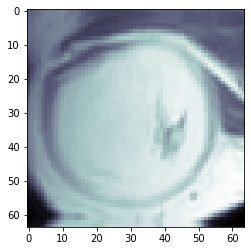

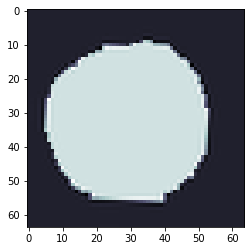

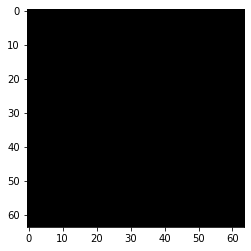

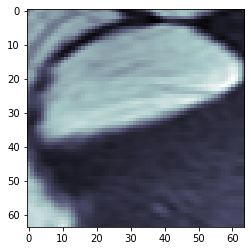

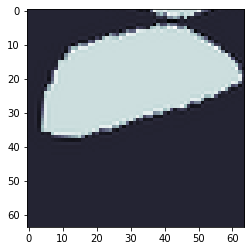

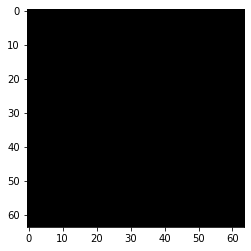

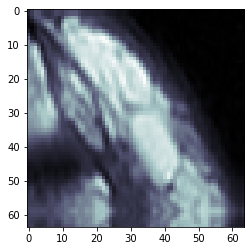

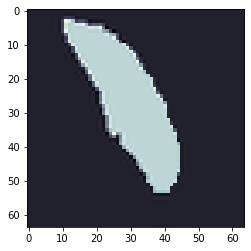

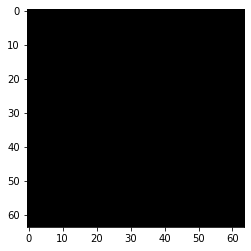

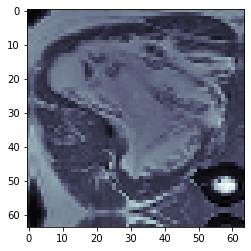

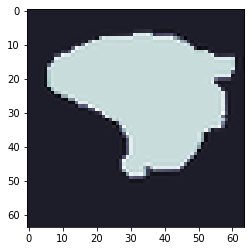

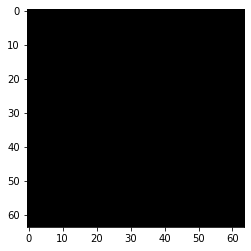

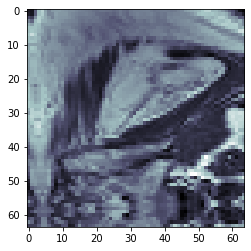

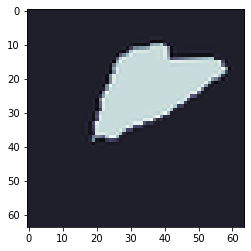

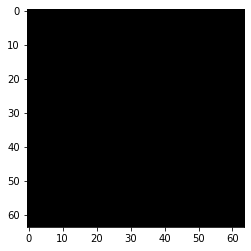

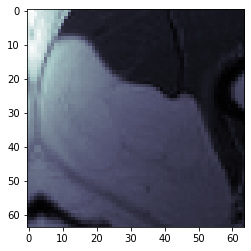

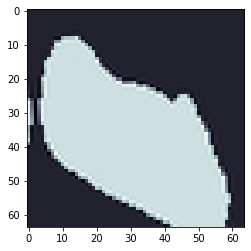

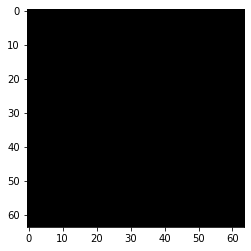

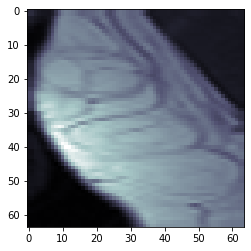

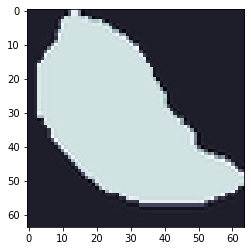

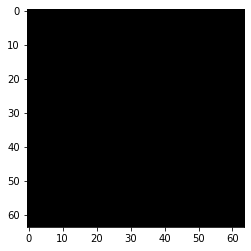

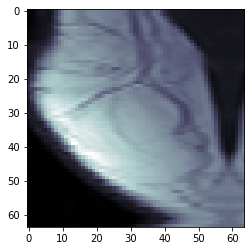

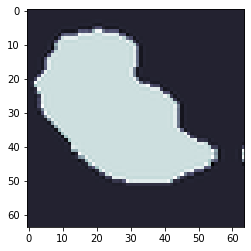

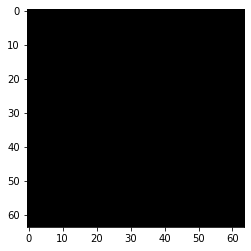

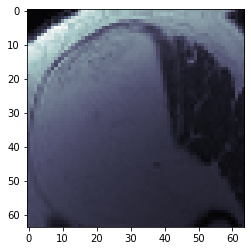

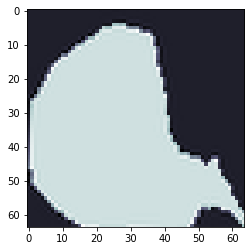

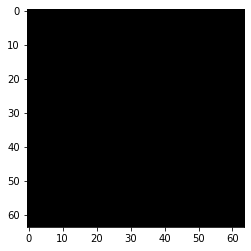

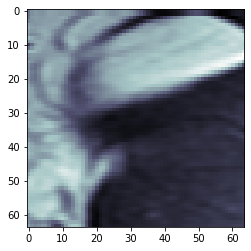

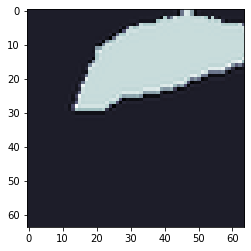

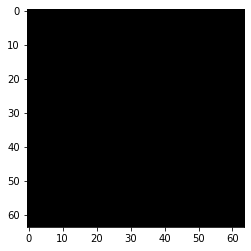

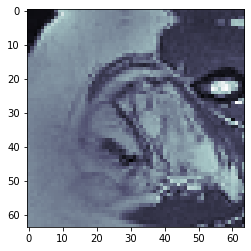

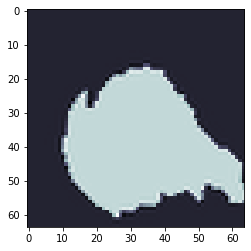

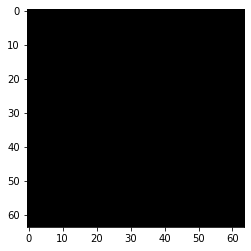

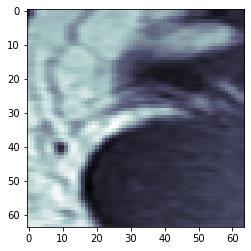

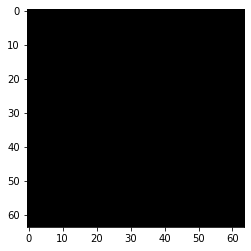

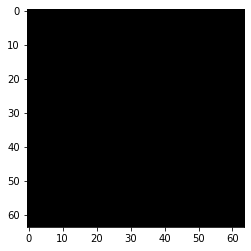

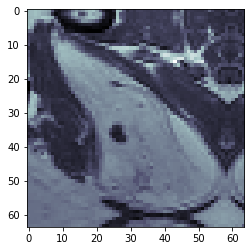

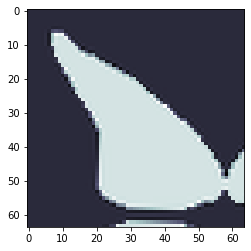

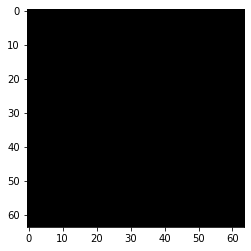

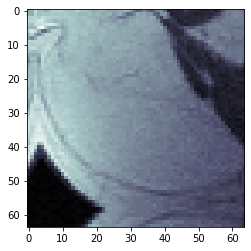

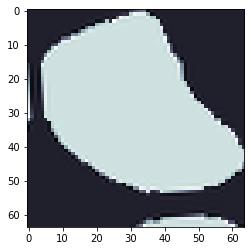

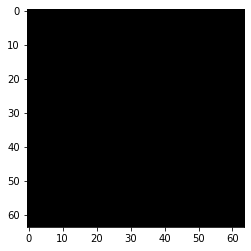

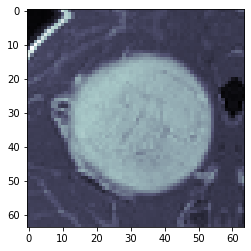

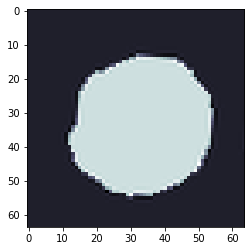

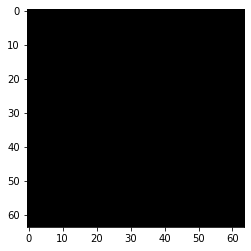

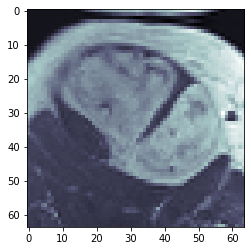

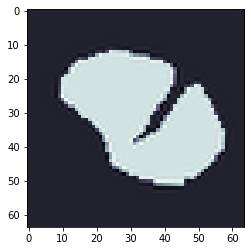

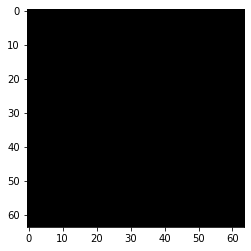

In [30]:
import matplotlib.pyplot as plt
best_model = torch.load('./best_model.pth')
model.eval()
x, y = niftiGen.get_batch(chunk_size=(64,64,1), batch_size=16 )
x_new = np.zeros((16,1,64,64))
for i in range(16):
    temp = x[i,:,:,:]
    temp1 = np.transpose(temp,(2,0,1))
    x_new[i,:,:,:] = temp1
y_new = np.zeros((16,1,64,64))
for i in range(16):
    temp = y[i,:,:,:]
    temp1 = np.transpose(temp,(2,0,1))
    y_new[i,:,:,:] = temp1
inputs, targets = torch.tensor(x_new, dtype=torch.double).to(DEVICE), torch.tensor(y_new, dtype=torch.double).to(DEVICE)
logits = model(inputs)
probabilities = F.softmax(logits, dim=1)
x1 = inputs.to('cpu')
x2 = targets.to('cpu')
x3 = probabilities.to('cpu').detach()

for idx in range(16):
    plt.figure()
    plt.imshow(x1[idx,0,:,:], cmap = plt.cm.bone)
    plt.figure()
    plt.imshow(x2[idx,0,:,:], cmap = plt.cm.bone)
    plt.figure()
    plt.imshow(x3[idx,0,:,:], cmap = plt.cm.bone)